# Lecture 17의 데모

### Lecture 17의 데모에 대한 코드

참고자료: 

https://github.com/data-8/materials-sp22/blob/main/lec/lec31.ipynb

https://github.com/data-8/materials-sp22/blob/main/lec/lec32.ipynb


In [114]:
import os
from google.colab import drive

drive.mount('/content/gdrive')

%cd /content/gdrive/MyDrive/ITEC419-fa22/lec

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/ITEC419-fa22/lec


In [115]:
from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

In [116]:
def make_correlated_data(r):
    x = np.random.normal(0, 1, 1000)
    z = np.random.normal(0, 1, 1000)
    y = r*x + (np.sqrt(1-r**2))*z
    return x, y

def r_table(r):
    """
    Generate a table of 1000 x,y data points in standard units
    whose correlation is approximately equal to r
    """
    np.random.seed(8)
    x, y = make_correlated_data(r)
    return Table().with_columns('x', x, 'y', y)

In [117]:
def demographics_errors(slope, intercept):
    # Use four convenient points from the original data
    sample = [[14.7, 33995], [19.1, 61454], [50.7, 71183], [59.5, 105918]]
    demographics.scatter('College%', 'Median Income', alpha=0.5)
    xlims = make_array(5, 75)
    # Plot a line with the slope and intercept you specified:
    plots.plot(xlims, slope * xlims + intercept, lw=4)
    # Plot red lines from each of the four points to the line
    for x, y in sample:
        plots.plot([x, x], [y, slope * x + intercept], color='r', lw=4)

In [118]:
def show_demographics_rmse(slope, intercept):
    demographics_errors(slope, intercept)
    x = demographics.column('College%')
    y = demographics.column('Median Income')
    prediction = slope * x + intercept
    mse = np.mean((y - prediction) ** 2)
    print("Root mean squared error:", round(mse ** 0.5, 2))

In [119]:
def fitted_values(t, x, y):
    """Return an array of the regressions estimates at all the x values"""
    a = slope(t, x, y)
    b = intercept(t, x, y)
    return a*t.column(x) + b

## **Slope & Intercept**

In [120]:
def standard_units(x): # x: 벡터 (굉장히 큰,,)
    """Converts an array x to standard units"""
    return (x - np.mean(x)) / np.std(x)

def correlation(t, x, y): # t라는 테이블에서 x라는 레이블의 칼람을 뽑아서 바꾸고 y도 스탠다드 유닛으로 바꿔서 
    """Computes correlation: t is a table, and x and y are column names"""
    x_su = standard_units(t.column(x))
    y_su = standard_units(t.column(y))
    return np.mean(x_su * y_su)#  평균으로 바꾸면


In [121]:
def slope(t, x, y): # t에 
    # ...
    r = correlation(t, x, y)
    y_sd = np.std(t.column(y))
    x_sd = np.std(t.column(x))
    return r * y_sd / x_sd
    
def intercept(t, x, y):
    # ...
    # mean_y - slope * mean_x
    mean_y = np.mean(t.column(y))
    mean_x = np.mean(t.column(x))
    return mean_y - slope(t, x, y) * mean_x

In [122]:
example = r_table(0.5) # correlation이 0.5가 되도록 하는...
slope(example, 'x', 'y')

0.50226382816259152

## **Heights data**

In [123]:
families = Table.read_table('heights.csv') # 부모와 자식의 키에 대한 데이터
families

family,father,mother,midparentHeight,children,childNum,gender,childHeight
1,78.5,67,75.43,4,1,male,73.2
1,78.5,67,75.43,4,2,female,69.2
1,78.5,67,75.43,4,3,female,69
1,78.5,67,75.43,4,4,female,69
2,75.5,66.5,73.66,4,1,male,73.5
2,75.5,66.5,73.66,4,2,male,72.5
2,75.5,66.5,73.66,4,3,female,65.5
2,75.5,66.5,73.66,4,4,female,65.5
3,75,64,72.06,2,1,male,71
3,75,64,72.06,2,2,female,68


In [124]:
families = Table.read_table('heights.csv')
# convert inches to cm
families.append_column('midparentHeight', families.apply(lambda x: np.round(x * 2.54, 1), 'midparentHeight'))
families.append_column('childHeight', families.apply(lambda x: np.round(x * 2.54, 1), 'childHeight'))

heights = Table().with_columns(
    'MidParent', families.column('midparentHeight'),
    'Child', families.column('childHeight'))
heights

MidParent,Child
191.6,185.9
191.6,175.8
191.6,175.3
191.6,175.3
187.1,186.7
187.1,184.2
187.1,166.4
187.1,166.4
183,180.3
183,172.7


In [125]:
def nn_prediction_heights(h): # h라는 부모의 평균키에서 1cm 만큼 빼고 더한 사이의 데이터들을 다 모아서 ... 
    """
    Return a prediction of the height of a child 
    whose parents have a midparent height of h.
    
    The prediction is the average height of the children 
    whose midparent height is in the range h plus or minus 1.0 centimeters.
    """
    neighbors = heights.where(
        'MidParent', are.between(h - 1.0, h + 1.0))# 이런 모든 데이터들을 모아서 자식의 평균키를 낸 것
    return np.mean(neighbors.column('Child'))

In [126]:
heights_with_predictions = heights.with_column(
    'Average neighbor prediction', 
    heights.apply(nn_prediction_heights, 'MidParent'))
heights_with_predictions 

MidParent,Child,Average neighbor prediction
191.6,185.9,178.075
191.6,175.8,178.075
191.6,175.3,178.075
191.6,175.3,178.075
187.1,186.7,178.863
187.1,184.2,178.863
187.1,166.4,178.863
187.1,166.4,178.863
183,180.3,174.094
183,172.7,174.094


In [127]:
heights_slope = slope(heights, 'MidParent', 'Child')
heights_intercept = intercept(heights, 'MidParent', 'Child')
heights_slope, heights_intercept

(0.63795310193361943, 57.391275141839088)

In [128]:
heights_with_predictions = heights_with_predictions.with_column(
    'Regression Prediction', 
    heights_slope*heights.column('MidParent') + heights_intercept
)
heights_with_predictions

MidParent,Child,Average neighbor prediction,Regression Prediction
191.6,185.9,178.075,179.623
191.6,175.8,178.075,179.623
191.6,175.3,178.075,179.623
191.6,175.3,178.075,179.623
187.1,186.7,178.863,176.752
187.1,184.2,178.863,176.752
187.1,166.4,178.863,176.752
187.1,166.4,178.863,176.752
183,180.3,174.094,174.137
183,172.7,174.094,174.137


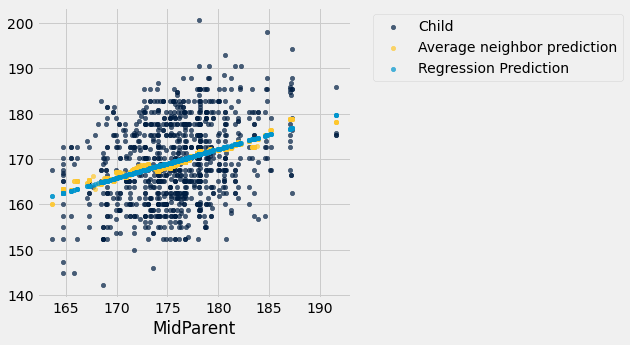

In [129]:
heights_with_predictions.scatter('MidParent')

### **Discussion Question**

In [130]:
mean_x = 70
sd_x = 10
mean_y = 50
sd_y = 12

r = 0.75

# (1) in standard units
x = 90

num_sds_x = (x-mean_x)/sd_x
num_sds_estimate_y = r*num_sds_x
y_pred = num_sds_estimate_y *sd_y+mean_y
y_pred

68.0

In [131]:
# (1) in original units (위랑 이것의 두가지 방법이 있음. )

slope_ = r*sd_y/sd_x #(ppt 6 page 참고)
intercept_ = mean_y-slope_*mean_x
y_pred = slope_*x+intercept_
y_pred

68.0

In [132]:
# (2) in standard units //
x = 60

num_sds_x = ...
num_sds_estimate_y = ...
y_pred = ...
y_pred

Ellipsis

In [133]:
# (2) in original units

slope_ = ...
intercept_ = ...
y_pred = ...
y_pred

Ellipsis


### **Error in Estimation**

In [134]:
demographics = Table.read_table('district_demographics2016.csv')
demographics.show(5) # 민주당과 공화당 중 어떤 걸 선택하는가 를 조사한 테이블 

State,District,Median Income,Percent voting for Clinton,College%
Alabama,"Congressional District 1 (115th Congress), Alabama",47083,34.1,24
Alabama,"Congressional District 2 (115th Congress), Alabama",42035,33,21.8
Alabama,"Congressional District 3 (115th Congress), Alabama",46544,32.3,22.8
Alabama,"Congressional District 4 (115th Congress), Alabama",41110,17.4,17
Alabama,"Congressional District 5 (115th Congress), Alabama",51690,31.3,30.3


In [135]:
demographics = demographics.drop(
    'State', 'District', 'Percent voting for Clinton')
demographics.show(5)

Median Income,College%
47083,24
42035,21.8
46544,22.8
41110,17
51690,30.3


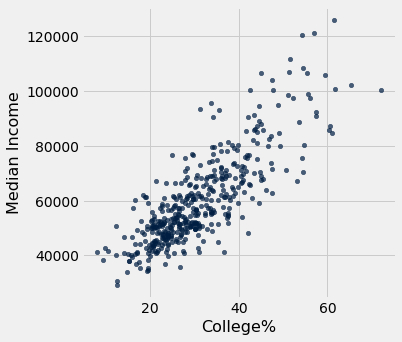

In [136]:
demographics.scatter('College%', 'Median Income')

In [137]:
correlation(demographics, 'College%', 'Median Income') # 0.8이라는 correlation이 있다. 

0.81846485171413352

In [138]:
regression_slope = slope(demographics, 'College%', 'Median Income')
regression_intercept = intercept(demographics, 'College%', 'Median Income')
regression_slope, regression_intercept

(1270.70168946388, 20802.577766677925)

In [139]:
predicted = fitted_values(demographics, 'College%', 'Median Income')

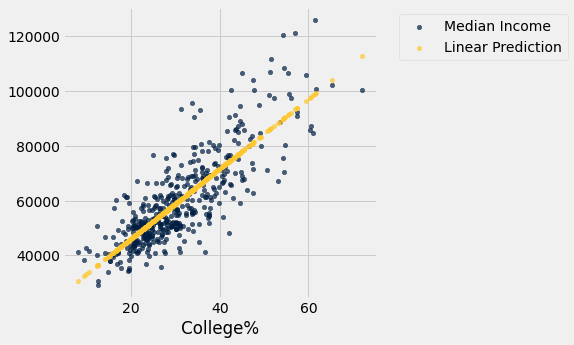

In [140]:
demographics = demographics.with_column(
    'Linear Prediction', predicted)
demographics.scatter('College%')

In [141]:
actual = demographics.column('Median Income')
errors = actual - predicted # 실제와 예측의 차이 

In [142]:
demographics.with_column('Error', errors)

Median Income,College%,Linear Prediction,Error
47083,24,51299.4,-4216.42
42035,21.8,48503.9,-6468.87
46544,22.8,49774.6,-3230.58
41110,17,42404.5,-1294.51
51690,30.3,59304.8,-7614.84
61413,36.7,67437.3,-6024.33
34664,19.4,45454.2,-10790.2
76440,29.6,58415.3,18024.7
50537,24.5,51934.8,-1397.77
49072,34,64006.4,-14934.4


In [143]:
np.mean(errors) # 거의 0임 (항상 0이 나옴 (-13=> 거의 0이라고 하심..))

6.3560089503211536e-13

In [144]:
np.mean(errors ** 2) ** 0.5 # 에러를 제곱해서 평균 구하고 다시 루트 -> dallor만큼 차이가ㅣ 잇다. 

9398.5155885712811

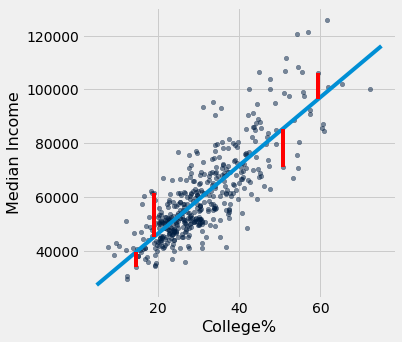

In [145]:
demographics_errors(regression_slope, regression_intercept) # 모든 점 마다 모두 에러가 있는 것임,,

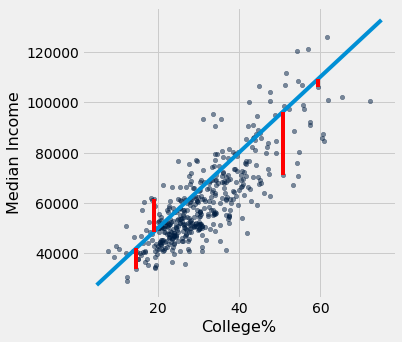

In [146]:
# takes any slope, any intercept

demographics_errors(1500, 20000) # 평균을 내서 루트를 취하면 더 커진다. 

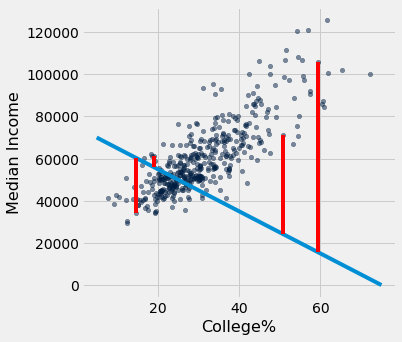

In [147]:
demographics_errors(-1000, 75000)

### **Root Mean Square Error** ###

Root mean squared error: 30247.88


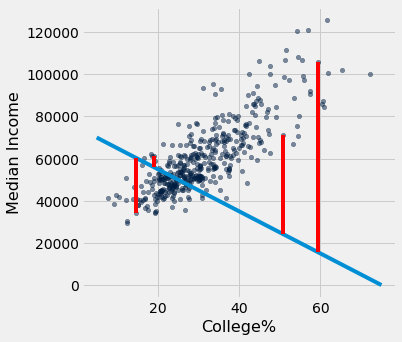

In [148]:
show_demographics_rmse(-1000, 75000)

Root mean squared error: 11559.09


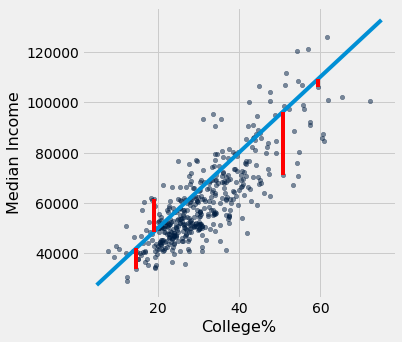

In [149]:
show_demographics_rmse(1500, 20000)

Root mean squared error: 9398.52


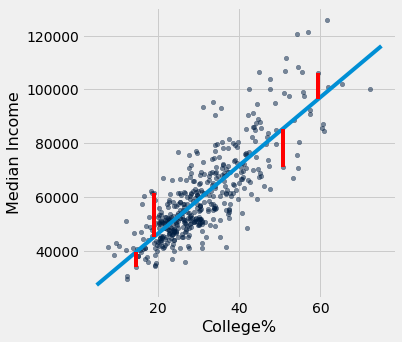

In [150]:
show_demographics_rmse(regression_slope, regression_intercept)

### **Numerical Optimization** ###

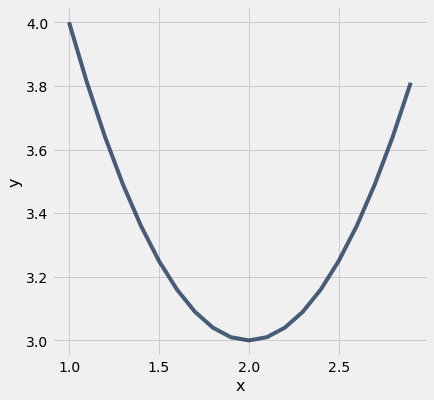

In [151]:
x = np.arange(1, 3, 0.1)
y = (x-2)**2 + 3
Table().with_columns('x', x, 'y', y).plot('x')

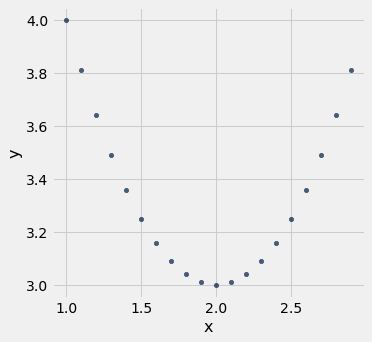

In [195]:
x = np.arange(1, 3, 0.1)
y = (x-2)**2 + 3
# Table().with_columns('x', x, 'y', y).plot('x')
Table().with_columns('x',x,'y',y).scatter('x') # 위에서 점으로 나타내게 바꾼것

In [196]:
def f(x):
    return ((x-2)**2) + 3

In [197]:
minimize(f) # 여기서 완벽하게 최소화 됨..

1.9999999946252267

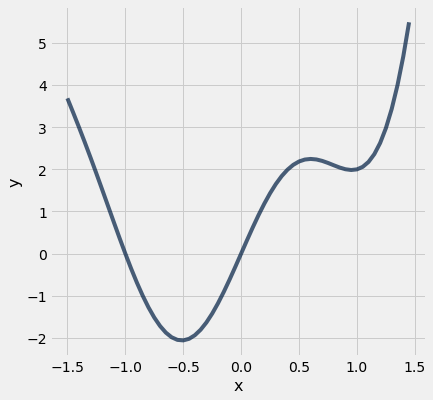

In [154]:
x = np.arange(-1.5, 1.5, 0.05)
y2 = 2 * np.sin(x*np.pi) + x ** 3 + x ** 4 
Table().with_columns('x', x, 'y', y2).plot('x')

In [155]:
def complicated_function(x):
    return 2 * np.sin(x*np.pi) + x ** 3 + x ** 4 

In [156]:
minimize(complicated_function)

-0.5126437620940081

### **Minimizing RMSE** ###

In [157]:
def demographics_rmse(any_slope, any_intercept):
    x = demographics.column('College%')
    y = demographics.column('Median Income')
    estimate = any_slope*x + any_intercept
    return (np.mean((y - estimate) ** 2)) ** 0.5

In [158]:
demographics_rmse(1500, 20000)

11559.086490075999

In [159]:
demographics_rmse(-1000, 75000)

30247.883767944502

In [160]:
minimize(demographics_rmse)

array([  1270.70168805,  20802.57933807])

In [161]:
make_array(regression_slope, regression_intercept)

array([  1270.70168946,  20802.57776668])

### **Nonlinear Regression** ###

In [162]:
shotput = Table.read_table('shotput.csv')
shotput

Weight Lifted,Shot Put Distance
37.5,6.4
51.5,10.2
61.3,12.4
61.3,13
63.6,13.2
66.1,13
70,12.7
92.7,13.9
90.5,15.5
90.5,15.8


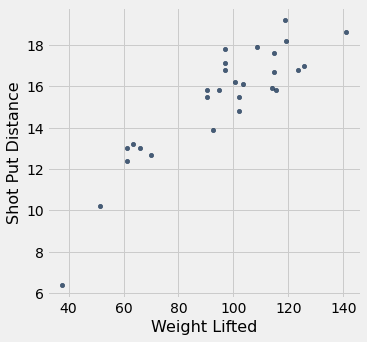

In [163]:
shotput.scatter('Weight Lifted')

In [164]:
def shotput_linear_rmse(any_slope, any_intercept):
    x = shotput.column('Weight Lifted')
    y = shotput.column('Shot Put Distance')
    estimate = any_slope*x + any_intercept
    return np.mean((y - estimate) ** 2) ** 0.5

In [165]:
best_line = minimize(shotput_linear_rmse)
best_line

array([ 0.09834382,  5.95962883])

In [166]:
weights = shotput.column(0)

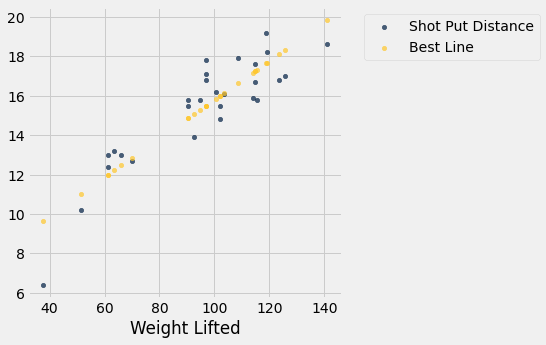

In [167]:
linear_fit = best_line.item(0)*weights + best_line.item(1)

shotput.with_column(
    'Best Line', linear_fit
).scatter(0)

**Quadratic Function**

$$
f(x) ~=~ ax^2 + bx + c
$$
for constants $a$, $b$, and $c$.



In [168]:
def shotput_quadratic_rmse(a, b, c):
    x = shotput.column('Weight Lifted')
    y = shotput.column('Shot Put Distance')
    estimate = a*(x**2) + b*x + c
    return np.mean((y - estimate) ** 2) ** 0.5

In [169]:
best_quad = minimize(shotput_quadratic_rmse)
best_quad

array([ -1.04003731e-03,   2.82706003e-01,  -1.53167618e+00])

In [170]:
# x = weight lifted = 100 kg
# Then predicted shot put distance:

(-0.00104)*(100**2) + 0.2827*100 - 1.5318

16.3382

In [171]:
quad_fit = best_quad.item(0)*(weights**2) + best_quad.item(1)*weights + best_quad.item(2)

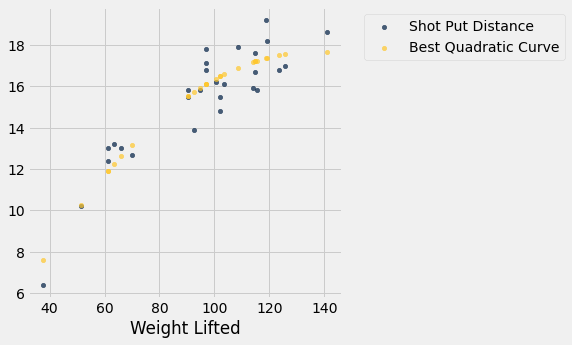

In [172]:
shotput.with_column('Best Quadratic Curve', quad_fit).scatter(0)

## **Residuals**

In [173]:
demographics = Table.read_table('district_demographics2016.csv')
demographics = demographics.drop(
    'State', 'District', 'Percent voting for Clinton')
demographics.show(5)

Median Income,College%
47083,24
42035,21.8
46544,22.8
41110,17
51690,30.3


In [174]:
def residuals(t, x, y):
    predictions = fitted_values(t, x, y)
    return t.column(y) - predictions 

In [175]:
demographics = demographics.with_columns(
    'Fitted Value', fitted_values(demographics, 'College%', 'Median Income'),
    'Residual', residuals(demographics, 'College%', 'Median Income')
)
demographics

Median Income,College%,Fitted Value,Residual
47083,24,51299.4,-4216.42
42035,21.8,48503.9,-6468.87
46544,22.8,49774.6,-3230.58
41110,17,42404.5,-1294.51
51690,30.3,59304.8,-7614.84
61413,36.7,67437.3,-6024.33
34664,19.4,45454.2,-10790.2
76440,29.6,58415.3,18024.7
50537,24.5,51934.8,-1397.77
49072,34,64006.4,-14934.4


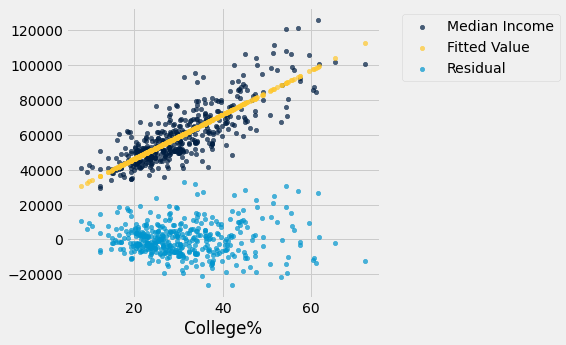

In [176]:
demographics.scatter('College%')

In [177]:
def plot_residuals(t, x, y):
    tbl = t.with_columns(
        'Fitted', fitted_values(t, x, y),
        'Residual', residuals(t, x, y)
    )
    tbl.select(x, y, 'Fitted').scatter(0)
    tbl.scatter(x, 'Residual', color='r')
    xlims = make_array(min(t.column(x)), max(t.column(x)))
    plots.plot(xlims, make_array(0, 0), color='darkblue', lw=4)

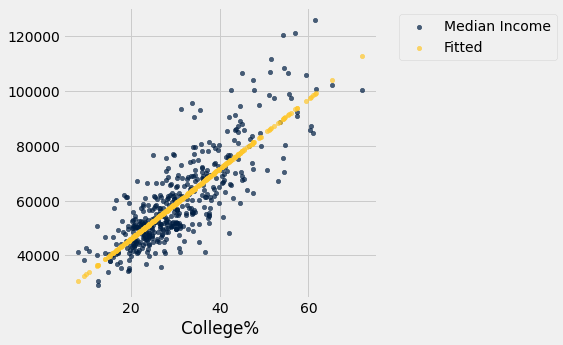

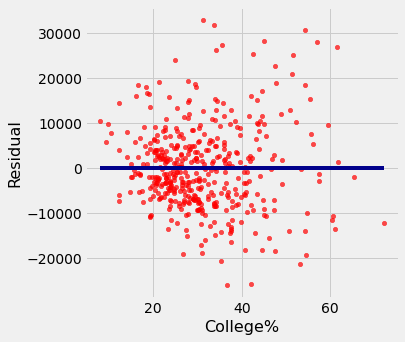

In [178]:
plot_residuals(demographics, 'College%', 'Median Income')

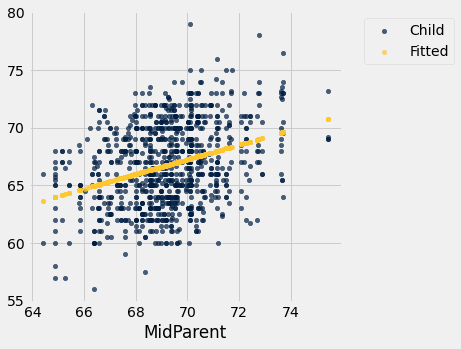

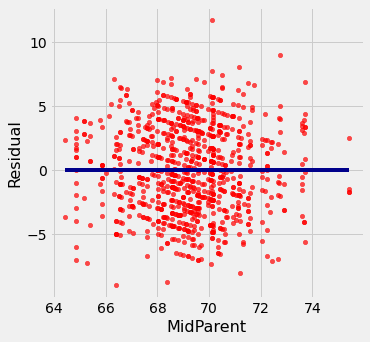

In [179]:
galton = Table.read_table('heights.csv')

heights = Table().with_columns(
    'MidParent', galton.column('midparentHeight'),
    'Child', galton.column('childHeight')
    )
plot_residuals(heights, 'MidParent', 'Child')

## **Dugongs** ##

In [180]:
dugong = Table.read_table('dugong.csv')
dugong.show(5)

Length,Age
1.8,1
1.85,1.5
1.87,1.5
1.77,1.5
2.02,2.5


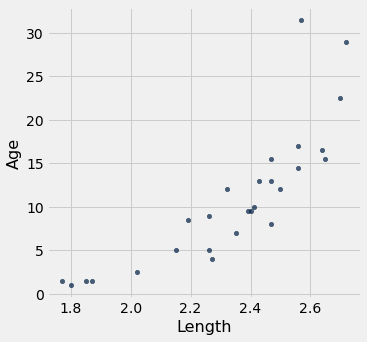

In [181]:
dugong.scatter('Length', 'Age')

In [182]:
correlation(dugong, 'Length', 'Age')

0.82964745549057139

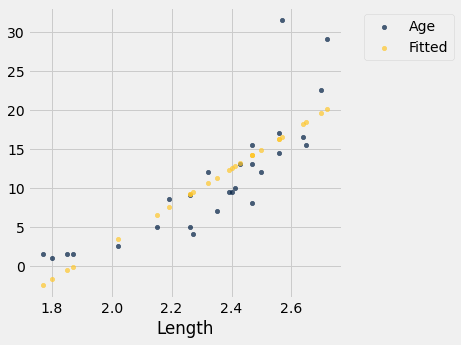

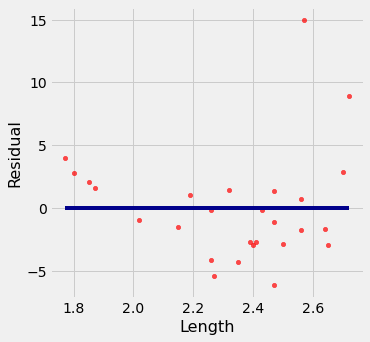

In [183]:
plot_residuals(dugong, 'Length', 'Age')

## **US Women**

In [184]:
us_women = Table.read_table('us_women.csv')
us_women.show(5)

height,ave weight
58,115
59,117
60,120
61,123
62,126


In [185]:
# convert inches to cm
us_women.append_column('height', us_women.apply(lambda x: np.round(x * 2.54, 1), 'height'))
# convert pound to kg
us_women.append_column('ave weight', us_women.apply(lambda x: np.round(x / 2.2046, 1), 'ave weight'))
us_women.show(5)

height,ave weight
147.3,52.2
149.9,53.1
152.4,54.4
154.9,55.8
157.5,57.2


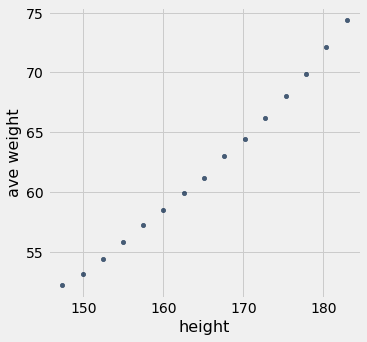

In [186]:
us_women.scatter('height')

In [187]:
correlation(us_women, 'height', 'ave weight')

0.99529613310886822

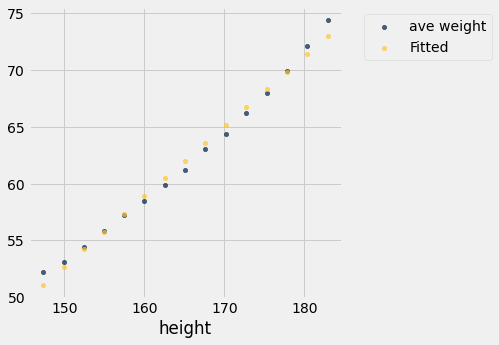

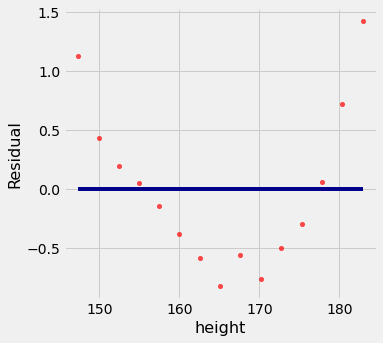

In [188]:
plot_residuals(us_women, 'height', 'ave weight')

## **Average of Residuals** ##

In [189]:
round(np.average(residuals(dugong, 'Length', 'Age')), 6)

0.0

In [190]:
round(np.average(residuals(heights, 'MidParent', 'Child')), 6)

0.0

In [191]:
round(np.average(residuals(demographics, 'College%', 'Median Income')), 6)

0.0

In [192]:
heights = heights.with_columns(
    'Residual', residuals(heights, 'MidParent', 'Child'),
    'Fitted Value', fitted_values(heights, 'MidParent', 'Child')
)

In [193]:
round(correlation(heights, 'MidParent', 'Residual'), 6)

-0.0

In [194]:
round(correlation(heights, 'Fitted Value', 'Residual'), 6)

-0.0